In [1]:
!pip install gymnasium

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64, learning_rate=0.001, device=device):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size).to(device)
        self.fc2 = nn.Linear(hidden_size, hidden_size).to(device)
        self.fc3 = nn.Linear(hidden_size, action_size).to(device)
                
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class FrozenLakeDQN:
    def __init__(self, learning_rate, discount_factor, sync_rate, replay_memory_size, batch_size, device=device):
        
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.sync_rate = sync_rate
        self.replay_memory = ReplayMemory(replay_memory_size)
        self.batch_size = batch_size
        self.optimizer = None
        self.loss_fn = nn.MSELoss()
        self.device = device
        

    def train(self, episodes, render=False, is_slippery=False):
        env = gym.make("FrozenLake-v1", is_slippery=is_slippery, render_mode='human' if render else None)
        n_states = env.observation_space.n
        n_actions = env.action_space.n
        epsilon = 1
        memory = ReplayMemory(self.replay_memory.capacity)

        policy_network = DQN(n_states, n_actions, learning_rate=self.learning_rate, device=self.device)
        target_network = DQN(n_states, n_actions, learning_rate=self.learning_rate, device=self.device)
        target_network.load_state_dict(policy_network.state_dict())
        
        self.optimizer = optim.Adam(policy_network.parameters(), lr=self.learning_rate)
        
        episode_rewards = np.zeros(episodes)
        epsilon_history = []
        step_count = 0
        
        np.bool8 = bool
        
        for episode in tqdm(range(episodes)):
            state = env.reset()[0]
            terminated, truncated = False, False
            
            while not terminated and not truncated:
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        action = policy_network(self.state_to_dqn_input(n_states, state)).argmax().item()

                new_state, reward, terminated, truncated, _ = env.step(action)
                memory.append((state, action, new_state, reward, terminated))
                state = new_state
                step_count += 1
            
            if reward == 1:
                episode_rewards[episode] = 1
            
            if len(memory) > self.batch_size and np.sum(episode_rewards) > 1:
                batch = memory.sample(self.batch_size)
                self.optimize(batch, policy_network, target_network)
                
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)
                
                if step_count % self.sync_rate == 0:
                    target_network.load_state_dict(policy_network.state_dict())
        
        env.close()
        
        torch.save(policy_network.state_dict(), r"models\frozen_lake_dqn.pth")

        plt.figure(1)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(episode_rewards[max(0, x - 100):(x + 1)])
        plt.subplot(121)
        plt.plot(sum_rewards)

        plt.subplot(122)
        plt.plot(epsilon_history)
        
        plt.savefig(r'figures\frozen_lake_dqn.png')
        
    def state_to_dqn_input(self, n_states, state):
        input_tensor = torch.zeros(n_states).to(self.device)
        input_tensor[state] = 1
        return input_tensor
        
    def optimize(self, batch, policy_network, target_network):
        n_states = policy_network.fc1.in_features
        current_q_list = []
        target_q_list = []
        for state, action, new_state, reward, terminated in batch:
            if terminated:
                target = torch.FloatTensor([reward])
            else:
                target = torch.FloatTensor(
                    [
                        reward + self.discount_factor * torch.max(target_network(self.state_to_dqn_input(n_states, new_state))).item()
                    ]
                )
            
            current_q = policy_network(self.state_to_dqn_input(n_states, state))
            current_q_list.append(current_q)
            
            target_q = target_network(self.state_to_dqn_input(n_states, state))
            target_q[action] = target
            target_q_list.append(target_q)
            
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [11]:
frozen_lake = FrozenLakeDQN(
    learning_rate=0.001,
    discount_factor=0.99,
    sync_rate=100,
    replay_memory_size=10000,
    batch_size=32
)

100%|██████████| 1000/1000 [50:47<00:00,  3.05s/it]


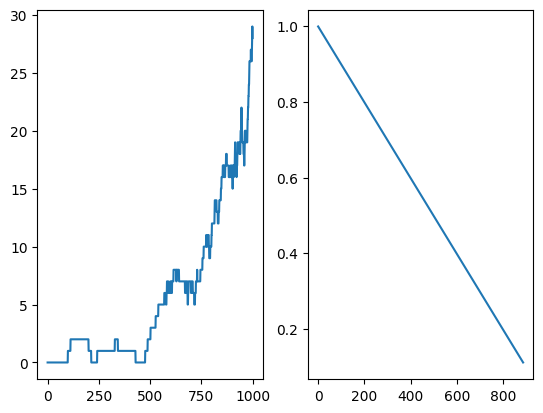

In [12]:
frozen_lake.train(episodes=1000, render=True, is_slippery=True)